In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import warnings
from sklearn.cluster import MiniBatchKMeans

warnings.filterwarnings('ignore')

# Load Data (Taken from Dr. Krehbiel's Code)

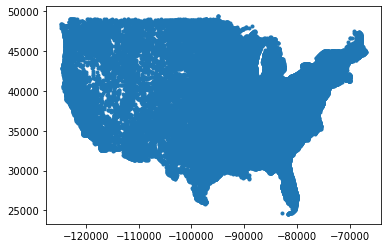

In [2]:
with open("cities.csv") as datafile:
    data = np.loadtxt(datafile, delimiter=" ")[:,1:] # chop of city indices
    
N = len(data)
    
CITIES = np.zeros((N,2)) #Two-dimensional array, one city's coordinates are CITIES[i,:]
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]

plt.plot(CITIES[:,0],CITIES[:,1],'.');


#  Helper Functions (Written by Dr. Krehbiel)

In [3]:
# calculates the distance between city_i and city_j
def dist(city_i,city_j):
    return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)

#tour is a list of integers that coorespond to the number of city
def tour_length(cities,tour):
    n = len(tour) #altered to make this function work for all tour lengths, rather than the set number of cities (only change)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(cities[tour[i-1],:],cities[tour[i],:])
    return length + dist(cities[tour[0],:],cities[tour[n-1],:])

## My Own Helper Functions and Variable Declarations

Variables to adjust and mess around with:

NUM_FITTEST:     controls the number of the best of the previous population we take into the next generation

SAMPLE_NUM:      controls the size of the sample we take when making the breeding pool

pop_size:        controls the number of tours we're keeping track of and comparing

MAX_ITERATIONS:  the current stopping condition -- the number of iterations

MUT_NUM         : 1/MUT_NUM is the chance for any single node to swap with a random other one during mutation

In [4]:
pop_size = 10  #the size of your population
NUM_FITTEST = int(pop_size/10) #proprtion of your pop to take as best
SAMPLE_NUM = 2 #number to sample when randomly selecting for breeding pool
MAX_ITERATIONS = 100
MUT_NUM = 100

In [5]:
num_cities = np.size(CITIES[:,0]) #the number of cities
breeding_pool = np.zeros((pop_size, num_cities), dtype = np.uint32)

#finds the n fittest cities in the current population
def n_fittest(cities, tours, n):
    total_num_tours = np.size(tours[:,0])
    lengths = np.zeros(total_num_tours) #array of all lengths of permutations
    for i in range(total_num_tours):
        lengths[i] = tour_length(cities,tours[i,:])
        
    best_tours = np.zeros((n, np.size(tours[0])))
    idx = (-lengths).argsort()[-n:]

    for i in range(n):
        best_tours[i,:] = tours[idx[i],:]
    
    return best_tours

#return the best of the n samples taken from population
def sample_best(cities, samples, n):
    lengths = np.zeros(n)
    for i in range(n):
        lengths[i] = tour_length(cities, samples[i])
        
    return samples[np.argmin(lengths),:]

#returns a child of two tours
def crossover(tour_1, tour_2):
    child = np.zeros(tour_1.shape)
    indices = [random.randint(0,num_cities-1), random.randint(0,num_cities-1)]
    indices.sort()
    t1_subset = tour_1[indices[0]:indices[1]]
    t2_possible = np.isin(tour_2, t1_subset)

    next_ind = 0 #keep track of the next index we take from tour_2
    for i in range(indices[0]):
        while(t2_possible[next_ind]): next_ind += 1
        child[i] = tour_2[next_ind]
        next_ind += 1
    child[indices[0]:indices[1]] = tour_1[indices[0]:indices[1]]
    for i in range(indices[1], np.size(tour_1)):
        while(t2_possible[next_ind]): next_ind += 1
        child[i] = tour_2[next_ind]
        next_ind += 1
        
    return child

## Genetic Algorithm

Iteration  0 took 15.148933172225952 seconds
Iteration  1 took 14.981434106826782 seconds
Iteration  2 took 14.547998905181885 seconds
Iteration  3 took 14.185792207717896 seconds
Iteration  4 took 14.760297536849976 seconds
Iteration  5 took 14.578983306884766 seconds
Iteration  6 took 14.487766981124878 seconds
Iteration  7 took 14.54003620147705 seconds
Iteration  8 took 14.40021800994873 seconds
Iteration  9 took 14.650184631347656 seconds
Iteration  10 took 14.31798505783081 seconds
Iteration  11 took 14.3995943069458 seconds
Iteration  12 took 14.041662454605103 seconds
Iteration  13 took 13.723401308059692 seconds
Iteration  14 took 15.179754257202148 seconds
Iteration  15 took 14.297964334487915 seconds
Iteration  16 took 14.237957000732422 seconds
Iteration  17 took 14.04922342300415 seconds
Iteration  18 took 14.167249202728271 seconds
Iteration  19 took 14.312740564346313 seconds
Iteration  20 took 13.83890700340271 seconds
Iteration  21 took 14.796777248382568 seconds
Itera

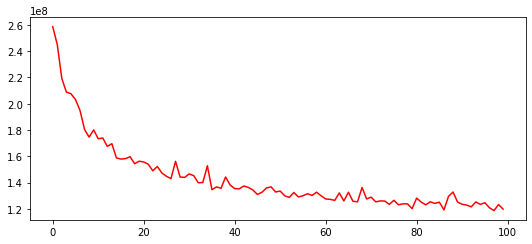

In [16]:
%%time
#Look above for control variables that have an effect on the time/quality of the algorithm
best_times = np.zeros(MAX_ITERATIONS)
times = np.zeros(pop_size)

#Initialize the population
pop = np.zeros((pop_size, num_cities), dtype = np.uint32) #rows correspond to a permutation
tour = np.array(range(num_cities)) #used to make other random tours
for i in range(pop_size):
    np.random.shuffle(tour)
    pop[i,:] = tour[:]

#running the algorithm
iterations = 0
whole_thing_start = time.time()
while(iterations < MAX_ITERATIONS):
    start = time.time()
    
    #shoutout Sam for the k-means idea
    NUM_CLUSTERS = (iterations+1)*5
    #From the sklearn library, assigns each datapoint in CITIES to one of the 2*(ITERATIONS+1) clusters
    kmeans = MiniBatchKMeans(n_clusters = NUM_CLUSTERS, batch_size = 1024).fit(CITIES)
    #labels_ outputs a list of size len(CITIES) where the indices correspond and contain
                                        #which cluster the city in index i is in
    labels = np.array(kmeans.labels_)
    cluster_t = []
    for i in range(NUM_CLUSTERS):
        cluster_t = cluster_t + list(np.where(labels == i)[0])
    cluster_tour = np.array(cluster_t)
    
    #making breeding pool
    breeding_pool[:NUM_FITTEST] = n_fittest(CITIES, pop, NUM_FITTEST) #add top fittest to breeding pool
    
    #fill the rest of the breeding pool by randomly sampling and taking the best of each sample
    for i in range(NUM_FITTEST, pop_size):
        alt_pop = pop.shape[0]
        breeding_pool[i] = sample_best(CITIES, pop[np.random.randint(pop.shape[0], size = SAMPLE_NUM)], SAMPLE_NUM)
        
    #making children
    pop[:NUM_FITTEST] = breeding_pool[:NUM_FITTEST] #adding the NUM_FITTEST parents as children
    #pop = breeding_pool
    
    #crossover
    for i in range(NUM_FITTEST, pop_size):
        two_parents = pop[np.random.randint(pop.shape[0], size = 2)]
        pop[i] = crossover(two_parents[0], two_parents[1])
        pop[i] = crossover(pop[i],cluster_tour)
        
    #mutation
    for i in range(pop_size):
        for j in range(num_cities-1):
            if(random.randint(0,MUT_NUM) == 1): #1/MUT_NUM chance of mutation for each element
                possible_indices = np.where(labels == labels[j])[0]#RESTRICTED SWAPPING
                swap_ind = possible_indices[random.randint(0,int(np.size(possible_indices))-1)]
                
                temp = pop[i,j+1]
                pop[i,j+1] = pop[i,swap_ind]
                pop[i,swap_ind] = temp
    
    for i in range(pop_size):
        times[i] = tour_length(CITIES, pop[i,:])
    best_times[iterations] = np.min(times)
    print("Iteration ",iterations,"took",time.time() - start, "seconds")#uncomment this to see how long each gen takes
    iterations += 1

plt.rcParams["figure.figsize"] = [7.5, 3.5]
plt.rcParams["figure.autolayout"] = True

x = range(MAX_ITERATIONS)
plt.plot(x, best_times, color="red")

In [17]:
print("The best time found was:")
print(np.min(best_times))

The best time found was:
118615797.7200555


## Notes:

The parameters for the above run is as follows:
pop_size = 10<br>
NUM_FITTEST = int(pop_size/10), so just keeping the top candidate from each generation<br>
SAMPLE_NUM = 2 <br>
MAX_ITERATIONS = 100 (stopping condition)<br>
MUT_NUM = 100 (1/100 chance for each city in the tour to mutate)<br>

Through some previous testing, there are some important notes about these parameters:
>-SAMPLE_NUM <= pop_size, but it should generally be about 2/3 to maintain exploration (prevent convergence to a local min).<br>
>-NUM_FITTEST should also be a relatively small portion of the population. I decided for my main run just to keep my top candidate because my population size was so small (population size has the greatest effect on how long it takes the program to run besides the number of iterations).<br>
>-A smaller MUT_NUM has the greatest effect on exploration. Originally, I tested this with 1/10,000 because the dataset was so large, but I realized after restricting the mutation randomness with K-means, that a chance of 1/100 would be much more appropriate to attain convergence.